In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

In [2]:
# Model Hyperparameters

dataset_path = 'datasets'

cuda = True
DEVICE = torch.device("cuda:0" if cuda else "cpu")

dataset = 'MNIST'
img_size = (32, 32, 3)   if dataset == "CIFAR10" else (28, 28, 1) # (width, height, channels)

timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

train_batch_size = 128
inference_batch_size = 64
lr = 5e-5
epochs = 200

seed = 1234

hidden_dims = [hidden_dim for _ in range(n_layers)]
torch.manual_seed(seed)
np.random.seed(seed)

## Step 1. Load (or download) Dataset

In [3]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False,  **kwargs)

## Step 2. Define our model: Denoising Diffusion Probabilistic Models (DDPMs)

Sinusoidal embedding for diffusion timestep

In [4]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In this tutorial, we use a simple stacked-convolution model with various dilations instead of UNet-like architecture.

In [5]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        
        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None
        
    def forward(self, x, time_embedding=None, residual=False):
        
        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y
        
        return y

In [6]:
class Denoiser(nn.Module):
    
    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim = 256, n_times=1000):
        super(Denoiser, self).__init__()
        
        _, _, img_C = image_resolution
        
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)
        
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)
        
        self.time_project = nn.Sequential(
                                 ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))
        
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])
        
        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                                    activation_fn=True, gn=True, gn_groups=8))                                
                               
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)
        
        
    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x
        
        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))
        
        y = self.in_project(y)
        
        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual = True)
            
        y = self.out_project(y)
            
        return y
    


In [8]:
class MyScheduler:
    def __init__(self, T=100, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.betas=torch.linspace(beta_start, beta_end, T).to(device)
        self.T = T
        self.alphas=1.0 - self.betas
        self.device=device

        self.sqrt_one_minus_betas = torch.sqrt(1.0 - self.betas)
        
        self.alpha_bars = torch.cumprod(self.alphas, dim=0) 
        
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - self.alpha_bars)

        self.sqrt_betas = torch.sqrt(self.betas)
        self.sqrt_alphas = torch.sqrt(self.alphas)

    def extract(self, a, t, x_shape): 
        """
        collect the values at time t from a and reshape it to x_shape
        
        a: precomputed one dimensional values
        t: time steps (scalar or tensor)
        x_shape: shape of the tensor to be returned 
        """
        
        b=t.shape[0]
        out=a.gather(-1, t)
        rt=out.reshape(b, *((1,) * (len(x_shape) - 1)))  #batch, unpack([1]*rest of the dimension)
        return rt  

    def get_xt(self, x0, t):
        """
        compute noisy image xt from x0 at time t 
        """ 
        eps=torch.randn_like(x0)
        # xt=x0 * self.sqrt_alpha_bars[t] + self.sqrt_one_minus_alpha_bars[t] * eps
        xt = x0 * self.extract(self.sqrt_alpha_bars, t, x0.shape) + eps * self.extract(self.sqrt_one_minus_alpha_bars, t, x0.shape)
        return xt, eps

In [9]:
class MyDDPM:
    def __init__(self, scheduler, noise_predictor_net, device='cuda'): 
        self.scheduler=scheduler
        self.noise_predictor_net=noise_predictor_net
        self.device=device
    
    def forward(self, x0):
        """ 
        noise x0 at random time t
        return noise, predicted noise
        """
        B= x0.shape[0]
        t=torch.randint(low=0, high=self.scheduler.T, size=(B,)).long().to(self.device)
        xt, eps=self.scheduler.get_xt(x0, t)
        eps_pred=self.noise_predictor_net(xt, t)
        return xt, eps, eps_pred
    
    
    def x_t_minus_1_from_x_t(self, t, x_t, eps_theta): 
        """ 
        Algorithm 2 in the DDPM paper
        """
        sqrt_alpha=self.scheduler.extract(self.scheduler.sqrt_alphas, t, x_t.shape)
        sqrt_one_minus_alpha_bar=self.scheduler.extract(self.scheduler.sqrt_one_minus_alpha_bars, t, x_t.shape)
        beta=self.scheduler.extract(self.scheduler.betas, t, x_t.shape)
        x_t_minus_1 = (1 / sqrt_alpha) * (x_t - ( beta / sqrt_one_minus_alpha_bar ) * eps_theta)
        
        # x_t_minus_1 = (1 / self.scheduler.sqrt_alphas[t]) * (x_t - ( self.scheduler.betas[t] / self.scheduler.sqrt_one_minus_alpha_bars[t] ) * eps_theta)
        return x_t_minus_1
    
    def sample_ddpm(self, nsamples, sample_shape):
        """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
        with torch.no_grad():
            x = torch.randn(size=(nsamples, *sample_shape)).to(self.device)   #start from random noise
            xts = [x]
            for it in range(self.scheduler.T-1, 0, -1):
                t=torch.tensor([it]).repeat_interleave(nsamples, dim=0).long().to(self.device)
                eps_theta = self.noise_predictor_net(x, t) 
                # See DDPM paper between equations 11 and 12
                x = self.x_t_minus_1_from_x_t(t, x, eps_theta) 
                if it > 1: # No noise for t=0
                    z = torch.randn(size=(nsamples, *sample_shape)).to(self.device)  
                    sqrt_beta=self.scheduler.extract(self.scheduler.sqrt_betas, t, x.shape)       #use fixed varience.
                    x += sqrt_beta* z
                xts += [x]
            return x, xts

In [10]:
# x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z

In [11]:
model = Denoiser(image_resolution=img_size,
                 hidden_dims=hidden_dims, 
                 diffusion_time_embedding_dim=timestep_embedding_dim, 
                 n_times=n_timesteps).to(DEVICE)

In [12]:
ms=MyScheduler(T=1000, beta_start=1e-4, beta_end=2e-2)
ddpm=MyDDPM(ms, model)

In [13]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print("Number of model parameters: ", count_parameters(diffusion))

In [14]:
batch=next(iter(test_loader))
X,y=batch

# x0=x0.unsqueeze(0).unsqueeze(0)
# x0.shape
# x0=x0.to(DEVICE)
i=10
x0=X[i].to(DEVICE)

In [18]:
xs=[]
n_times=1000
ts=[1, 10, 20,  n_times//8,   n_times//4, n_times//2, n_times-1]
for ti in ts:
    t = torch.randint(low=0, high= n_times, size=(1,)).long().to(ms.device)
    t[0]=ti    

    xt,eps=ddpm.scheduler.get_xt(x0, t)
    xt=xt.squeeze().cpu().numpy()
    xs.append(xt)
xt.shape 

(28, 28)

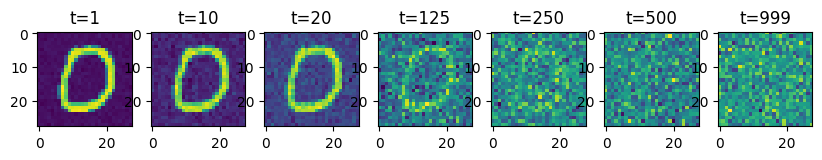

In [19]:
plt.figure(figsize=(10,3))
for i,xt in enumerate(xs):
    plt.subplot(1,len(xs),i+1)
    plt.imshow(xt)
    plt.title(f"t={ts[i]}")

In [21]:
optimizer = Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [22]:
epochs

200

In [23]:
print("Start training DDPMs...")
model.train()

for epoch in range(epochs):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
         
        x_zeros = x.to(DEVICE) 
        B = x_zeros.shape[0] 
        
        t = torch.randint(low=0, high=ms.T, size=(B,)).long().to(ms.device)  
        xt, eps = ms.get_xt(x_zeros, t)
        
        pred_eps=model(xt, t) 
        loss=loss_fn(eps, pred_eps) 
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        noise_prediction_loss += loss.item()
        
        
    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / batch_idx)
    
print("Finish!!")

Start training DDPMs...


100%|██████████| 469/469 [00:31<00:00, 14.74it/s]

	Epoch 1 complete! 	Denoising Loss:  0.06925820287428477



100%|██████████| 469/469 [00:31<00:00, 14.81it/s]


	Epoch 2 complete! 	Denoising Loss:  0.02635586081454769


100%|██████████| 469/469 [00:31<00:00, 14.79it/s]

	Epoch 3 complete! 	Denoising Loss:  0.023392327790522676



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 4 complete! 	Denoising Loss:  0.022197607924572677



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 5 complete! 	Denoising Loss:  0.021091701192224126



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 6 complete! 	Denoising Loss:  0.020243279152334884



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 7 complete! 	Denoising Loss:  0.019867094444572672



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 8 complete! 	Denoising Loss:  0.019300365613566503



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 9 complete! 	Denoising Loss:  0.019091878834570575



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 10 complete! 	Denoising Loss:  0.01895379889000239



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 11 complete! 	Denoising Loss:  0.01872830057882855



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 12 complete! 	Denoising Loss:  0.01827706694483566



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 13 complete! 	Denoising Loss:  0.018200442439709336



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 14 complete! 	Denoising Loss:  0.017936958004043907



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 15 complete! 	Denoising Loss:  0.017949753974238012



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 16 complete! 	Denoising Loss:  0.01772504464054528



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 17 complete! 	Denoising Loss:  0.017556094628177647



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 18 complete! 	Denoising Loss:  0.017414078381087664



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 19 complete! 	Denoising Loss:  0.01739774457513331



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 20 complete! 	Denoising Loss:  0.017148165649169277



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 21 complete! 	Denoising Loss:  0.017042453152040005



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 22 complete! 	Denoising Loss:  0.01714667304355301



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 23 complete! 	Denoising Loss:  0.016910142971712172



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 24 complete! 	Denoising Loss:  0.016763102464202758



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 25 complete! 	Denoising Loss:  0.01662831630311015



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 26 complete! 	Denoising Loss:  0.01680020268401529



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 27 complete! 	Denoising Loss:  0.01675198551737027



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 28 complete! 	Denoising Loss:  0.016525550801147763



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 29 complete! 	Denoising Loss:  0.01651252510670859



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 30 complete! 	Denoising Loss:  0.016382853247814327



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 31 complete! 	Denoising Loss:  0.01639051740177167



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 32 complete! 	Denoising Loss:  0.016257511812031396



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 33 complete! 	Denoising Loss:  0.01617229327909712



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 34 complete! 	Denoising Loss:  0.01623539697840555



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 35 complete! 	Denoising Loss:  0.01604640854196225



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]


	Epoch 36 complete! 	Denoising Loss:  0.015910289413494687


100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 37 complete! 	Denoising Loss:  0.016012903462108385



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 38 complete! 	Denoising Loss:  0.016040288355663165



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 39 complete! 	Denoising Loss:  0.015750866283813857



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 40 complete! 	Denoising Loss:  0.01599321930876209



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 41 complete! 	Denoising Loss:  0.015751082203390762



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 42 complete! 	Denoising Loss:  0.015769301844028454



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 43 complete! 	Denoising Loss:  0.01583149351585561



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 44 complete! 	Denoising Loss:  0.015706461362747684



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 45 complete! 	Denoising Loss:  0.015586204597981185



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]


	Epoch 46 complete! 	Denoising Loss:  0.015773554923585974


100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 47 complete! 	Denoising Loss:  0.01582033757486532



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 48 complete! 	Denoising Loss:  0.015584473649406025



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 49 complete! 	Denoising Loss:  0.01546250101035604



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 50 complete! 	Denoising Loss:  0.015608655016184745



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 51 complete! 	Denoising Loss:  0.015576418308127258



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]


	Epoch 52 complete! 	Denoising Loss:  0.015544095860682746


100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 53 complete! 	Denoising Loss:  0.01557397212371485



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 54 complete! 	Denoising Loss:  0.015504606042264236



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 55 complete! 	Denoising Loss:  0.01549399563939207



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 56 complete! 	Denoising Loss:  0.01538222406903266



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 57 complete! 	Denoising Loss:  0.015257683719914312



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 58 complete! 	Denoising Loss:  0.015508049742804252



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 59 complete! 	Denoising Loss:  0.015391289119202739



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 60 complete! 	Denoising Loss:  0.015229065106528947



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 61 complete! 	Denoising Loss:  0.015321572687333593



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 62 complete! 	Denoising Loss:  0.015299258027305333



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]


	Epoch 63 complete! 	Denoising Loss:  0.01525103653438835


100%|██████████| 469/469 [00:31<00:00, 14.77it/s]


	Epoch 64 complete! 	Denoising Loss:  0.015401114058943514


100%|██████████| 469/469 [00:31<00:00, 14.78it/s]


	Epoch 65 complete! 	Denoising Loss:  0.01532115612545202


100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 66 complete! 	Denoising Loss:  0.015251588382813921



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 67 complete! 	Denoising Loss:  0.015139257821899194



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 68 complete! 	Denoising Loss:  0.015289973674548997



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 69 complete! 	Denoising Loss:  0.015131368222208614



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 70 complete! 	Denoising Loss:  0.015190905682408275



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 71 complete! 	Denoising Loss:  0.014884841660212757



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 72 complete! 	Denoising Loss:  0.015276166705940014



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 73 complete! 	Denoising Loss:  0.015011185995088173



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 74 complete! 	Denoising Loss:  0.015118478580465557



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 75 complete! 	Denoising Loss:  0.01501163311748423



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 76 complete! 	Denoising Loss:  0.015098308686676443



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 77 complete! 	Denoising Loss:  0.014974048333322136



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 78 complete! 	Denoising Loss:  0.014954531358347999



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 79 complete! 	Denoising Loss:  0.014978282434197191



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 80 complete! 	Denoising Loss:  0.014956037941762907



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 81 complete! 	Denoising Loss:  0.01504060771698371



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 82 complete! 	Denoising Loss:  0.014910181558444204



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 83 complete! 	Denoising Loss:  0.01491613369076871



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 84 complete! 	Denoising Loss:  0.014872925182899985



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 85 complete! 	Denoising Loss:  0.014892146464946687



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 86 complete! 	Denoising Loss:  0.014774660207729181



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 87 complete! 	Denoising Loss:  0.014988368635790216



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 88 complete! 	Denoising Loss:  0.014901793287255062



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 89 complete! 	Denoising Loss:  0.014954301240081843



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 90 complete! 	Denoising Loss:  0.01495617150894215



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 91 complete! 	Denoising Loss:  0.01472280372101336



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 92 complete! 	Denoising Loss:  0.014849870587086193



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 93 complete! 	Denoising Loss:  0.014647872037946796



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 94 complete! 	Denoising Loss:  0.014799857054415166



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 95 complete! 	Denoising Loss:  0.01489151362528722



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 96 complete! 	Denoising Loss:  0.014749236321315551



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 97 complete! 	Denoising Loss:  0.014765161790081069



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 98 complete! 	Denoising Loss:  0.01479627594200528



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 99 complete! 	Denoising Loss:  0.014801596645584218



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 100 complete! 	Denoising Loss:  0.014548257733575808



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 101 complete! 	Denoising Loss:  0.014739314937948162



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 102 complete! 	Denoising Loss:  0.014896111761848642



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 103 complete! 	Denoising Loss:  0.014605004975221988



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 104 complete! 	Denoising Loss:  0.014497587041388083



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 105 complete! 	Denoising Loss:  0.014700729774040544



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 106 complete! 	Denoising Loss:  0.014545684057470953



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 107 complete! 	Denoising Loss:  0.014817750708271678



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 108 complete! 	Denoising Loss:  0.014800287820956009



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 109 complete! 	Denoising Loss:  0.014731387870434003



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 110 complete! 	Denoising Loss:  0.014585217039108787



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 111 complete! 	Denoising Loss:  0.014736187234361712



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 112 complete! 	Denoising Loss:  0.014656884410681251



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 113 complete! 	Denoising Loss:  0.014805863746720502



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 114 complete! 	Denoising Loss:  0.014511788164416695



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 115 complete! 	Denoising Loss:  0.014474376283872586



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]


	Epoch 116 complete! 	Denoising Loss:  0.014549432183082541


100%|██████████| 469/469 [00:31<00:00, 14.77it/s]


	Epoch 117 complete! 	Denoising Loss:  0.014658847055596929


100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 118 complete! 	Denoising Loss:  0.014612643961579753



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 119 complete! 	Denoising Loss:  0.014473188155068036



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 120 complete! 	Denoising Loss:  0.01461275582973901



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 121 complete! 	Denoising Loss:  0.014675660990178585



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 122 complete! 	Denoising Loss:  0.014442535320249123



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 123 complete! 	Denoising Loss:  0.014455989044971572



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 124 complete! 	Denoising Loss:  0.014576895528624201



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 125 complete! 	Denoising Loss:  0.014571175249850648



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 126 complete! 	Denoising Loss:  0.014665516754055126



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 127 complete! 	Denoising Loss:  0.014584930679307152



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 128 complete! 	Denoising Loss:  0.014512645156305825



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 129 complete! 	Denoising Loss:  0.014574182006872745



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 130 complete! 	Denoising Loss:  0.014489355384626895



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 131 complete! 	Denoising Loss:  0.014483269815468509



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 132 complete! 	Denoising Loss:  0.01428703432624093



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 133 complete! 	Denoising Loss:  0.014486796190787075



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 134 complete! 	Denoising Loss:  0.014581612856565123



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 135 complete! 	Denoising Loss:  0.014500711748026248



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 136 complete! 	Denoising Loss:  0.014199254103004932



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 137 complete! 	Denoising Loss:  0.014413026354522405



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 138 complete! 	Denoising Loss:  0.01433808147174935



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 139 complete! 	Denoising Loss:  0.014393181504251866



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 140 complete! 	Denoising Loss:  0.014470488177294023



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 141 complete! 	Denoising Loss:  0.014518114039674401



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 142 complete! 	Denoising Loss:  0.014393635163815994



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 143 complete! 	Denoising Loss:  0.014391399460295454



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 144 complete! 	Denoising Loss:  0.014382761749876743



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 145 complete! 	Denoising Loss:  0.014343802749505665



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 146 complete! 	Denoising Loss:  0.014342746960046964



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 147 complete! 	Denoising Loss:  0.01425511022615764



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 148 complete! 	Denoising Loss:  0.014552198760370668



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 149 complete! 	Denoising Loss:  0.014455891307841381



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 150 complete! 	Denoising Loss:  0.01445380166077461



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 151 complete! 	Denoising Loss:  0.014463719070101013



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 152 complete! 	Denoising Loss:  0.01438449078804662



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 153 complete! 	Denoising Loss:  0.014610922278470209



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 154 complete! 	Denoising Loss:  0.014264150562449398



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 155 complete! 	Denoising Loss:  0.014345002915853491



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 156 complete! 	Denoising Loss:  0.014385648203106264



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 157 complete! 	Denoising Loss:  0.014206881262760004



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 158 complete! 	Denoising Loss:  0.014396565303636285



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 159 complete! 	Denoising Loss:  0.014238397875386808



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 160 complete! 	Denoising Loss:  0.014387880836048314



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 161 complete! 	Denoising Loss:  0.014185452674571266



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 162 complete! 	Denoising Loss:  0.014306230209847419



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 163 complete! 	Denoising Loss:  0.014296976938987007



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 164 complete! 	Denoising Loss:  0.014343246964849213



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 165 complete! 	Denoising Loss:  0.014247100219194196



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 166 complete! 	Denoising Loss:  0.01444818384738432



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 167 complete! 	Denoising Loss:  0.014260662908657875



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 168 complete! 	Denoising Loss:  0.014345065400036227



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 169 complete! 	Denoising Loss:  0.01428334291976614



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 170 complete! 	Denoising Loss:  0.01420212903808261



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 171 complete! 	Denoising Loss:  0.014214689053324426



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 172 complete! 	Denoising Loss:  0.014378930256964687



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 173 complete! 	Denoising Loss:  0.014438254549765052



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 174 complete! 	Denoising Loss:  0.014372692950881826



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 175 complete! 	Denoising Loss:  0.014288165321987536



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 176 complete! 	Denoising Loss:  0.014225161329914745



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 177 complete! 	Denoising Loss:  0.014368268547770686



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 178 complete! 	Denoising Loss:  0.014289430165504161



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 179 complete! 	Denoising Loss:  0.01434807231824877



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 180 complete! 	Denoising Loss:  0.014336323532729577



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 181 complete! 	Denoising Loss:  0.014208028194470665



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]


	Epoch 182 complete! 	Denoising Loss:  0.01444132415116088


100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 183 complete! 	Denoising Loss:  0.01428394058607837



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 184 complete! 	Denoising Loss:  0.014045887244626498



100%|██████████| 469/469 [00:31<00:00, 14.79it/s]

	Epoch 185 complete! 	Denoising Loss:  0.014340498914512305



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 186 complete! 	Denoising Loss:  0.014219269393266648



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 187 complete! 	Denoising Loss:  0.01399757548306997



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 188 complete! 	Denoising Loss:  0.01420260296187276



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 189 complete! 	Denoising Loss:  0.01428443673822997



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 190 complete! 	Denoising Loss:  0.014243224958101144



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 191 complete! 	Denoising Loss:  0.014123589435242053



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 192 complete! 	Denoising Loss:  0.013950478966132952



100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

	Epoch 193 complete! 	Denoising Loss:  0.014153038173452275



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 194 complete! 	Denoising Loss:  0.014292071738606717



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 195 complete! 	Denoising Loss:  0.014140698899570694



100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

	Epoch 196 complete! 	Denoising Loss:  0.01429533096165675



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 197 complete! 	Denoising Loss:  0.01410885358778521



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 198 complete! 	Denoising Loss:  0.014193240959101763



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 199 complete! 	Denoising Loss:  0.014218779822063243



100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

	Epoch 200 complete! 	Denoising Loss:  0.014147561849453129
Finish!!


In [24]:
x,xts=ddpm.sample_ddpm(1, (1, 28, 28))
x.shape

torch.Size([1, 1, 28, 28])

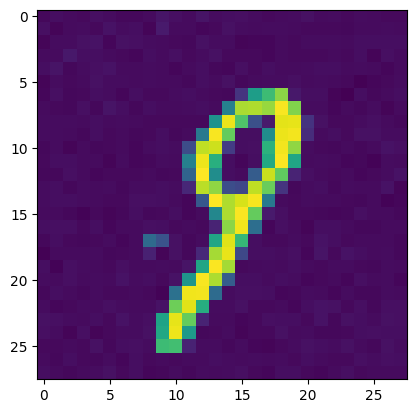

In [25]:
tx=x.detach().cpu().numpy().squeeze()
plt.imshow(tx)

In [26]:
inference_batch_size

64

In [27]:
x,xts=ddpm.sample_ddpm(inference_batch_size, (1, 28, 28))
x.shape

torch.Size([64, 1, 28, 28])

In [28]:
batch=next(iter(test_loader))
Xt, yt = batch
Xt.shape

torch.Size([64, 1, 28, 28])

### Comparison with ground-truth samples

In [29]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [30]:
# draw_sample_image(perturbed_images, "Perturbed Images")

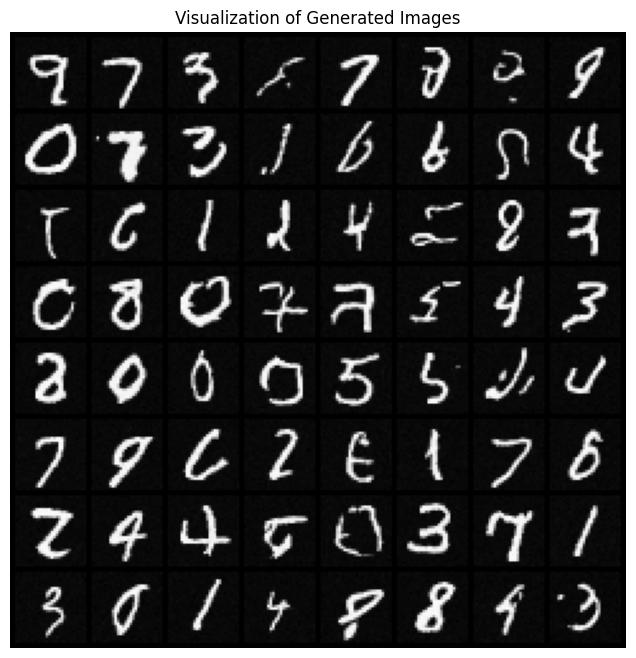

In [31]:
draw_sample_image(x, "Generated Images")

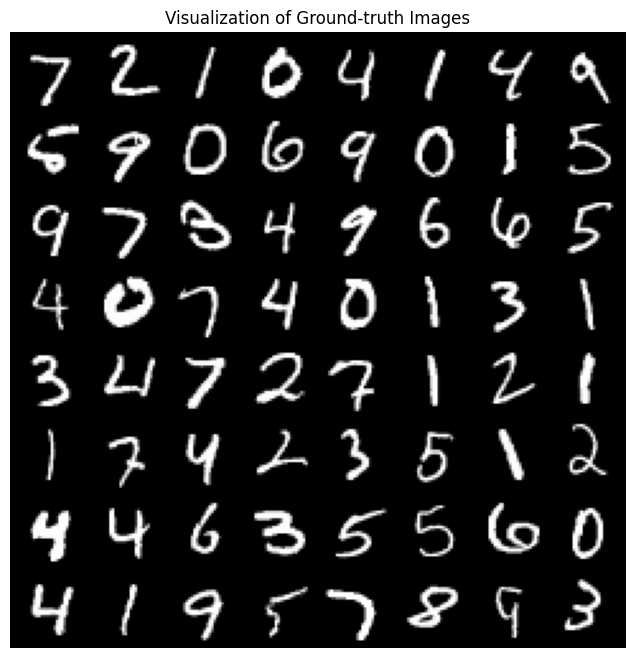

In [32]:
draw_sample_image(Xt[:inference_batch_size], "Ground-truth Images")

In [60]:
x,xts=ddpm.sample_ddpm(1, (1, 28, 28))
x.shape

torch.Size([1, 1, 28, 28])

In [61]:
xtss=[x.detach().cpu().numpy().squeeze() for x in xts]
len(xtss)

1000

In [62]:
len(xtss), xtss[0].shape, xtss[1].shape

(1000, (28, 28), (28, 28))

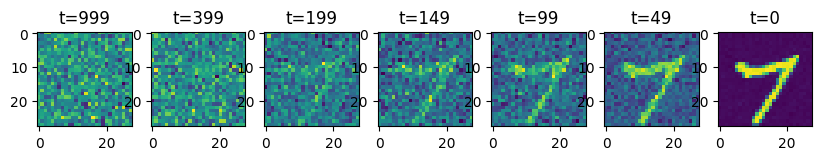

In [63]:
st=[0, 600,  800, 850, 900, 950, 999]

plt.figure(figsize=(10, 4))
for i in st:
    plt.subplot(1, len(st), st.index(i)+1)
    plt.imshow(xtss[i])
    plt.title(f"t={999-i}") 
    plt.gca().set_aspect('equal')

In [64]:
import imageio

imageio.mimsave('ddpm_mnist2.gif', xtss, fps=15)

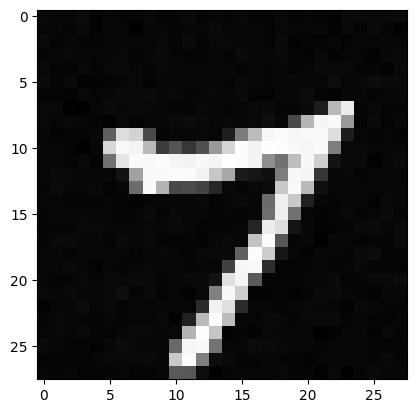

In [65]:
import matplotlib.animation as animation


fig = plt.figure()
ims = []
for i in range(len(xtss)):
    im = plt.imshow(xtss[i], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat_delay=1000)
animate.save('ddpm_mnist22.gif')
plt.show()

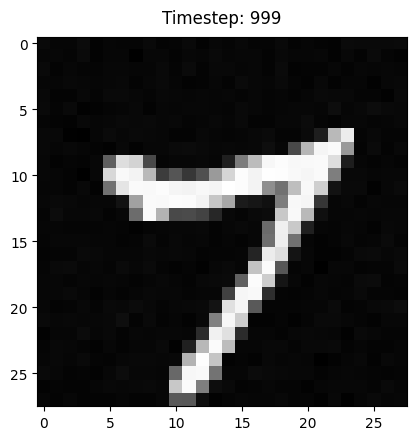

In [80]:
fig = plt.figure()
ims = []

# for i in range(0, len(xtss),10):
i=0
while i < len(xtss):
    im = plt.imshow(xtss[i], cmap="gray", animated=True)  # Image for the current timestep
    timestep_text = plt.text(0.5, 1.05, f"Timestep: {i}", 
                             fontsize=12, ha="center", va="center", transform=plt.gca().transAxes) 
    ims.append([im, timestep_text])  # Add the image and text to the frame
    
    if i>900:
        i +=5
    elif i>700:
        i +=10
    else:
        i = i + 20  # Skip 10 timesteps to speed up the animation
    


# Repeat the last frame to create a pause
pause_frames = 20  # Adjust the number of frames to control pause duration
for j in range(pause_frames):
    im = plt.imshow(xtss[-1], cmap="gray", animated=True)
    timestep_text = plt.text(0.5, 1.05, f"Timestep: {len(xtss) - 1}",
                             fontsize=12, ha="center", va="center", transform=plt.gca().transAxes)
    ims.append([im, timestep_text])


animate = animation.ArtistAnimation(fig, ims, interval=2, blit=True, repeat_delay=3000)
animate.save('ddpm_mnist22.gif')
plt.show()